In [1]:
import tensorflow as tf
import os
print(tf.__version__)

2.5.0


In [51]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report,accuracy_score,f1_score
from tqdm import tqdm,trange

In [3]:
df_data = pd.read_csv("ner_dataset.csv",sep=",",encoding="latin1").fillna(method='ffill')
df_data

,ID,Word,Tag
0,0,NGUYEN MINH HIEN,Name
1,0,Co-Founder/COO,Position
2,0,Grooo International JSC,Company
3,0,https://www.grooo.vn,Website
4,0,"2F, NO9-B2 Building,",Address
...,...,...,...
5678,429,"Minato-ku, Tokyo 107-8077, Japan",Address
5679,429,Committed to the global good. TEL +81-3-3497-7135,Phones
5680,429,FAX +81-3-3497-7471,Other
5681,429,E-mail : kato-shuichi@itochu.co.jp,Email


In [4]:
tag_list=df_data.Tag.unique()
tag_list

array(['Name', 'Position', 'Company', 'Website', 'Address', 'Phones',
       'Email', 'Other'], dtype=object)

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test=train_test_split(df_data,test_size=0.20,shuffle=False)

In [6]:
x_train.shape,x_test.shape

((4546, 3), (1137, 3))

In [7]:
agg_func = lambda s: [ [w,t] for w,t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]

In [8]:
x_train_grouped = x_train.groupby("ID").apply(agg_func)
x_test_grouped = x_test.groupby("ID").apply(agg_func)

In [9]:
x_train_sentences = [[s[0] for s in sent] for sent in x_train_grouped.values]
x_test_sentences = [[s[0] for s in sent] for sent in x_test_grouped.values]


In [10]:
x_train_tags = [[t[1] for t in tag] for tag in x_train_grouped.values]
x_test_tags = [[t[1] for t in tag] for tag in x_test_grouped.values]

In [11]:
np.shape(x_train_tags),np.shape(x_test_tags)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


((331,), (86,))

In [12]:
MAX_LENGTH=200
# BERT_MODEL="bert-base-multilingual-cased"
BERT_MODEL='bert-base-cased'
BATCH_SIZE=32

pad_token=0,
pad_token_segment_id=0,
sequence_a_segment_id=0,

In [13]:
from transformers import (
    TF2_WEIGHTS_NAME,
    BertConfig,
    BertTokenizer,
    TFBertForTokenClassification,
    create_optimizer)

In [14]:
MODEL_CLASSES = {"bert": (BertConfig, TFBertForTokenClassification, BertTokenizer)}

In [15]:
label_map = {label: i+1 for i, label in enumerate(tag_list)}
label_map

{'Name': 1,
 'Position': 2,
 'Company': 3,
 'Website': 4,
 'Address': 5,
 'Phones': 6,
 'Email': 7,
 'Other': 8}

In [16]:
num_labels = len(tag_list) + 1
num_labels

9

In [17]:
pad_token_label_id = 0

In [18]:
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [19]:
config = config_class.from_pretrained(BERT_MODEL,num_labels=num_labels)

In [20]:
tokenizer = tokenizer_class.from_pretrained(BERT_MODEL,do_lower_case=False)

In [21]:
from keras.preprocessing.sequence import pad_sequences
max_seq_length =200

def convert_to_input(sentences,tags):
  input_id_list,attention_mask_list,token_type_id_list=[],[],[]
  label_id_list=[]
  
  for x,y in tqdm(zip(sentences,tags),total=len(tags)):
  
    tokens = []
    label_ids = []

    for word, label in zip(x, y):
      word_tokens = tokenizer.tokenize(word.lower())
      tokens.extend(word_tokens)
      # Use the real label id for the first token of the word, and padding ids for the remaining tokens
      label_ids.extend([label_map[label]]  * (len(word_tokens)))

  
    special_tokens_count =  2
    if len(tokens) > max_seq_length - special_tokens_count:
      tokens = tokens[: (max_seq_length - special_tokens_count)]
      label_ids = label_ids[: (max_seq_length - special_tokens_count)]

    label_ids = [pad_token_label_id]+label_ids+[pad_token_label_id]
    inputs = tokenizer.encode_plus(tokens,add_special_tokens=True, max_length=max_seq_length)

    input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]
    attention_masks = [1] * len(input_ids)

    attention_mask_list.append(attention_masks)
    input_id_list.append(input_ids)
    token_type_id_list.append(token_type_ids)

    label_id_list.append(label_ids)

  return input_id_list,token_type_id_list,attention_mask_list,label_id_list
# 

In [22]:
input_ids_train,token_ids_train,attention_masks_train,label_ids_train=convert_to_input(x_train_sentences,x_train_tags)

100%|███████████████████████████████████████████████████████████████████████████████| 331/331 [00:01<00:00, 307.95it/s]


In [23]:
input_ids_test,token_ids_test,attention_masks_test,label_ids_test=convert_to_input(x_test_sentences,x_test_tags)

100%|█████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 377.41it/s]


In [24]:
input_ids_train = pad_sequences(input_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
token_ids_train = pad_sequences(token_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
attention_masks_train = pad_sequences(attention_masks_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
label_ids_train = pad_sequences(label_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")

In [25]:
np.shape(input_ids_train),np.shape(token_ids_train),np.shape(attention_masks_train),np.shape(label_ids_train),

((331, 200), (331, 200), (331, 200), (331, 200))

In [26]:
input_ids_test = pad_sequences(input_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
token_ids_test = pad_sequences(token_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
attention_masks_test = pad_sequences(attention_masks_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
label_ids_test = pad_sequences(label_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")

In [27]:
np.shape(input_ids_test),np.shape(token_ids_test),np.shape(attention_masks_test),np.shape(label_ids_test),

((86, 200), (86, 200), (86, 200), (86, 200))

In [28]:
input_ids_train.shape

(331, 200)

In [29]:
input_ids_train[1]

array([  101, 21174, 20257,  1424, 11241,  1324, 20844,  1424,  2448,
        2308,  2417,  4265,  1372,  2345, 11437,  1182,  1106,  3781,
        1186,   192,  2246,  1830,  9715,  1995,  2728,  1584,  1148,
        3590,   126,  2087,   123,   118,   123,   118,   125, 20844,
       11305,  3031,   118,   188,  8265, 15446,  3624,   188,  8265,
       15446,  3624,   118,   180,  1358,   117,  1106,  3781,  1186,
         179, 26519,  1179, 21359,  1233,   131,   116,  5615,   118,
         124,   118,  3324, 23493,   118, 27832,  1580,   175,  7897,
         131,   116,  5615,   118,   124,   118,  5486, 11964,   118,
        6032,  1604,  1495,  5093,   131,   113,   116,  5731,   114,
       21787,   118,  5840,   118,  3140, 25041,   179,  1643,  1775,
         174,   118,  6346,   131, 11241, 23830,  8584,   118, 21174,
       20257,  1424,   137,   192,  2246,  4832, 21459,   119,   179,
        1643,   170,  7767,  3923,  1372,   190, 17670,   131,  8413,
         131,   120,

In [30]:
tokenizer.vocab_size

28996

In [31]:
from keras import Model,Input
from keras.layers import LSTM,Embedding,Dense
from keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
import tensorflow_addons as tfa
from keras.regularizers import l2

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [32]:
max_len=200
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = tokenizer.vocab_size, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
# model = Bidirectional(LSTM(units = 50,return_sequences = True, recurrent_dropout = 0.5,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(model)
model = Bidirectional(LSTM(units = 128,return_sequences = True, recurrent_dropout = 0.5))(model)
out = TimeDistributed(Dense(num_labels,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          5799200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          336896    
_________________________________________________________________
time_distributed (TimeDistri (None, 200, 9)            2313      
Total params: 6,138,409
Trainable params: 6,138,409
Non-trainable params: 0
_________________________________________________________________


In [33]:
max_len=200
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss

In [34]:
# input_word = Input(shape = (max_len,))
# model = Embedding(input_dim = 119547, output_dim = max_len, input_length = max_len)(input_word)
# model = SpatialDropout1D(0.1)(model)
# model = Bidirectional(LSTM(units = 100,return_sequences = True, recurrent_dropout = 0.1))(model)
# # model = tfa.layers.CRF(num_tags )(model)
# # model = TimeDistributed(Dense(max_len, activation="relu"))(model)
# out= CRF(num_labels)(model)
# model = Model(input_word,out)
# crf = tfa.layers.CRF(num_labels)
# model.compile(optimizer = 'adam',loss= 'sparse_categorical_crossentropy', metrics = [ 'accuracy'])
# model.summary()

In [35]:
history=model.fit(input_ids_train, label_ids_train, batch_size = 64, verbose = 1, epochs = 50, validation_split = 0.1)

Epoch 1/50
5/5 [==============================] - 52s 3s/step - loss: 2.1317 - accuracy: 0.3613 - val_loss: 1.8460 - val_accuracy: 0.3793
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 1.7412 - accuracy: 0.3623 - val_loss: 1.4734 - val_accuracy: 0.5293
Epoch 3/50
5/5 [==============================] - 11s 2s/step - loss: 1.4605 - accuracy: 0.5133 - val_loss: 1.3603 - val_accuracy: 0.5916
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 1.3645 - accuracy: 0.5583 - val_loss: 1.2132 - val_accuracy: 0.5601
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: 1.2083 - accuracy: 0.5495 - val_loss: 1.1446 - val_accuracy: 0.5493
Epoch 6/50
5/5 [==============================] - 11s 2s/step - loss: 1.1377 - accuracy: 0.5660 - val_loss: 1.0735 - val_accuracy: 0.6534
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 1.0709 - accuracy: 0.6504 - val_loss: 0.9704 - val_accuracy: 0.6825
Epoch 8/50
5/5 [==================

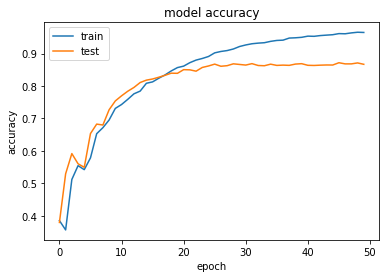

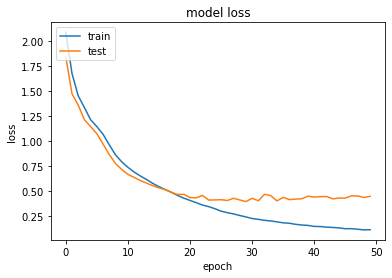

In [36]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# model.load_weights('Card_4_model_200_LSTM_128_weights.h5')
# model.save_weights('Card_model_200_LSTM_weights.h5')

In [43]:
model.evaluate(input_ids_train, label_ids_train)

11/11 [==============================] - 2s 159ms/step - loss: 0.1240 - accuracy: 0.9631


[0.124038927257061, 0.9630513787269592]

In [44]:
model.evaluate(input_ids_test, label_ids_test)

3/3 [==============================] - 0s 114ms/step - loss: 0.5225 - accuracy: 0.8646


[0.5225161910057068, 0.8645930290222168]

In [45]:
for i in range(300):
    print(i,'\n', input_ids_train[i])

0 
 [  101 21174 20257  1424 11241  1324 20844  1424  1884   118  3249   120
  1884  1186   176 24886  1186  1835   179  1116  1665 18630   131   120
   120  7001   119   176 24886  1186   119   191  1179   123  2087   117
  1185  1580   118   171  1477  1459   117  1190  1324 24438  3814  2472
   117  4267  1732  3262  1403  7910   117 11019  1358   176  1465  1183
  1629   117  5871  2728  1182   117   191 22331 12881   116  5731   118
   125   118  5073  1545   118  5539   118  5599  1545   116  5731   118
 21787   118  5840  1527   118  3140  1527 20844  1424   137   176 24886
  1186   119   191  1179 20844  1424   137   176 24886  1186   119   191
  1179   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

 [  101   175  6451   119   175  6451  3594   189  4047   186 25530 14086
   113   189  4060   114  3073   118  3813   111  4301  9496 10908 19937
   111   187  4163   120   170  1182  5093   131   116  5731  3164  1545
  5037  1604  6032  1604 10632   131 14086  1777  1477   137   175  7301
  4964   119  3254   119   191  1179   175  6451 11019  1358   176  1465
  1183  1459   117  1542  3840  1183 15925   188 18062   119   117 11019
  1358   176  1465  1183  4267  2050   119   117  5871  2728  1182   117
   191 22331 12881 21359  1233   131   116  5731   113  1572   114  3413
  1545  1604 21500 19203   184 10908 19937  7001   119   175  6451   118
  3594   119  3254  7001   119   175  6451   118  3594   119  3254   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  

In [55]:

acc=[]
for n in range(85):
    # word=tokenizer.decode(input_ids_test[n])
# print('Words:  \n',word)
# print('='*100)
# print('Tokens: \n',np.array(tokenizer.tokenize(word)).reshape(-1))
# y_pred = model.predict(input_ids_test[n:(n+1)])
# print('='*100)
# print('Label Pridict: \n',np.argmax(y_pred, axis=-1).reshape(-1))    
# print('='*100)
# print('Label True:    \n',label_ids_test[n:(n+1)])
# from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Test với toàn bộ tập test
    y_pred = model.predict(input_ids_test[n:(n+1)])
    y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
    y_test_true = label_ids_test[n].reshape(-1)
    acc.append(f1_score(y_test_true, y_pred,average='macro'))

# Kiểm thử F1-Score
# y_pred = [[tag_idx[i] for i in row] for row in y_pred]
# y_test_true = [[tag_idx[i] for i in row] for row in y_test_true]
# print('='*100)

# print("Accuracy is : {:.1%}".format(f1_score(y_test_true, y_pred,average='macro')))
# print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred,average='macro')))
# print("Precision_score: {:.1%}".format(precision_score(y_test_true, y_pred,average='macro')))
# print("Recall_score is : {:.1%}".format(recall_score(y_test_true, y_pred,average='macro')))

In [57]:
erorr=[]
for i in range(len(acc)):
    if acc[i]<0.8:
        erorr.append(i)      
print(len(erorr))
print(erorr)

44
[14, 15, 16, 18, 20, 21, 23, 24, 28, 29, 30, 31, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 57, 60, 61, 62, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81]


In [64]:
n=2
word=tokenizer.decode(input_ids_test[n])
print('Words:  \n',word)
print('='*100)
tokens=np.array(tokenizer.tokenize(word)).reshape(-1)
print('Tokens: \n',np.array(tokenizer.tokenize(word)).reshape(-1))
y_pred = model.predict(input_ids_test[n:(n+1)])
print('='*100)
y_pred=np.argmax(y_pred, axis=-1).reshape(-1)
print('Label Predict: \n',y_pred)    
print('='*100)
print('Label True:    \n',label_ids_test[n:(n+1)])
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Test với toàn bộ tập test
y_pred = model.predict(input_ids_test[n:(n+1)])
y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
y_test_true = label_ids_test[n].reshape(-1)


print('='*100)
target_names = ['PAD','Name', 'Position', 'Company', 'Other', 'Address']
print(classification_report(y_test_true , y_pred, target_names=target_names))
kq=pd.DataFrame(list(zip(tokens, y_pred,y_test_true)),columns =['Tokens', 'Predict','true'])
kq.Predict=kq.Predict.replace({0:'PAD',1:'Name',2:'Position',5:'Address',3:'Company',4:'Other'})
kq['true']=kq['true'].replace({0:'PAD',1:'Name',2:'Position',5:'Address',3:'Company',4:'Other'})

kq.head(60)

Words:  
 [CLS] bbx internet exchange naotake aj onoda director global ix sales department bb ix, inc. tokyo shiodome building 1 - 9 - 1 higashishinbashi minatoku tokyo 105 - 7310, japan tel : + 81 - 3 - 6889 - 9257 fax : + 81 - 3 - 6889 - 6614 mobile : + 81 - 80 - 9648 - 5446 e - mail : naotake. onoda @ bbix. net http : / / www. bbix. net / e - mail : naotake. onoda @ bbix. net http : / / www. bbix. net / [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Tokens: 
 ['[CLS]' 'b' '##b' '##x' 'internet' 'exchange' 'na' '##ota' '##ke' 'a'
 '##j' 'on' '##oda' 'director' 'global' 'i' '##x' 'sales' 'department' 'b'
 '##b' 'i' '##x' ',' 'in' '##c' '.' 'to' '##ky' '##o' 's' '##hi' '##od'
 '##ome' 'building' '1' '-' '9' '-' '1' 'hi' '##gas' '##his' '##hin'
 '##bas' '##hi' 'min' '##ato' '##ku

TypeError: classification_report() got an unexpected keyword argument 'target_names'

In [ ]:
y_pred = model.predict(input_ids_test[n:(n+1)])
np.argmax(y_pred, axis=-1).reshape(-1)

In [ ]:
label_ids_test[n:(n+1)]

In [89]:

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Test với toàn bộ tập test
y_pred = model.predict(input_ids_test)
y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
y_test_true = label_ids_test.reshape(-1)

# Kiểm thử F1-Score
# y_pred = [[tag_idx[i] for i in row] for row in y_pred]
# y_test_true = [[tag_idx[i] for i in row] for row in y_test_true]
# target_names = ['PAD','Name', 'Position', 'Company', 'Other', 'Address']
# target_names=['PAD','Name', 'Position', 'Company', 'Website', 'Address', 'Phones','Email', 'Other']
print(classification_report(y_test_true , y_pred, target_names=['PAD','Name', 'Position', 'Company', 'Website', 'Address', 'Phones','Email', 'Other']))

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00      5276
        Name       0.82      0.70      0.75       652
    Position       0.85      0.51      0.64       523
     Company       0.70      0.56      0.62       988
     Website       0.89      0.82      0.85       783
     Address       0.91      0.94      0.92      3093
      Phones       0.85      0.77      0.81      2038
       Email       0.94      0.82      0.87      1377
       Other       0.63      0.83      0.72      2470

    accuracy                           0.86     17200
   macro avg       0.84      0.77      0.80     17200
weighted avg       0.87      0.86      0.86     17200



In [84]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Test với toàn bộ tập train
y_pred = model.predict(input_ids_train)
y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
y_test_true = label_ids_train.reshape(-1)

# Kiểm thử F1-Score
# y_pred = [[tag_idx[i] for i in row] for row in y_pred]
# y_test_true = [[tag_idx[i] for i in row] for row in y_test_true]
target_names = ['PAD','Name', 'Position', 'Company', 'Other', 'Address']
print(classification_report(y_test_true , y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8]))
kq=pd.DataFrame(list(zip(tokens, y_pred,y_test_true)),columns =['Tokens', 'Predict','True'])
kq

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20825
           1       0.93      0.90      0.92      2379
           2       0.90      0.84      0.87      1962
           3       0.92      0.91      0.91      3386
           4       0.96      0.96      0.96      2955
           5       0.98      0.99      0.98     11444
           6       0.97      0.93      0.95      7809
           7       0.99      0.96      0.97      4517
           8       0.90      0.95      0.92     10923

    accuracy                           0.96     66200
   macro avg       0.95      0.94      0.94     66200
weighted avg       0.96      0.96      0.96     66200



,Tokens,Predict,True
0,[CLS],0,0
1,b,1,1
2,##b,1,1
3,##x,1,1
4,internet,1,1
...,...,...,...
195,[PAD],0,0
196,[PAD],0,0
197,[PAD],0,0
198,[PAD],0,0


In [90]:
from sklearn.metrics import classification_report
y_pred = model.predict(input_ids_test)
y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
y_test_true = label_ids_test.reshape(-1)
target_names = ['PAD','Name', 'Position', 'Company', 'Other', 'Address']
print(classification_report(y_test_true , y_pred, target_names=['PAD','Name', 'Position', 'Company', 'Website', 'Address', 'Phones','Email', 'Other']))

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00      5276
        Name       0.82      0.70      0.75       652
    Position       0.85      0.51      0.64       523
     Company       0.70      0.56      0.62       988
     Website       0.89      0.82      0.85       783
     Address       0.91      0.94      0.92      3093
      Phones       0.85      0.77      0.81      2038
       Email       0.94      0.82      0.87      1377
       Other       0.63      0.83      0.72      2470

    accuracy                           0.86     17200
   macro avg       0.84      0.77      0.80     17200
weighted avg       0.87      0.86      0.86     17200



In [82]:
n=84
y_pred = model.predict(input_ids_test[n:(n+1)])
y_pred = np.argmax(y_pred, axis=-1).reshape(-1)
y_test_true = label_ids_test[n].reshape(-1)
target_names = ['PAD','Name', 'Position', 'Company', 'Website', 'Address', 'Phones', 'Email', 'Other']
print(classification_report(y_test_true , y_pred, target_names=np.unique(y_test_true)))

TypeError: classification_report() got an unexpected keyword argument 'target_names'

In [48]:
input_ids_test

array([[  101,  1122,  9962, ...,     0,     0,     0],
       [  101,  1940, 10337, ...,     0,     0,     0],
       [  101,   171,  1830, ...,     0,     0,     0],
       ...,
       [  101,  1107,  6094, ...,     0,     0,     0],
       [  101, 24928,  1665, ...,  3383, 11964,   102],
       [  101,  1122,  9962, ...,     0,     0,     0]])

In [ ]:
rand_sent = np.random.randint(0, X_test.shape[0]) # get a random sentense
print(rand_sent)
p = model.predict(np.array([X_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(X_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))

In [ ]:
# rand_sent = np.random.randint(0, X_test.shape[0]) # get a random sentense
# print(rand_sent)
tmp_w=[]
tmp_t=[]
tmp_p=[]
tmp_i=[]
for i in range(len(X_test)):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis = -1)
    y_true = np.argmax(np.array(y_test), axis = -1)[i] # get actual tags for random sentense
    print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
    print("-" * 55)

    for (w, t, pred) in zip(X_test[i], y_true, p[0]):
        tmp_w.append(words[w - 1])
        tmp_t.append(tags[t])
        tmp_p.append(tags[pred])
        tmp_i.append(i)

In [ ]:
kq=pd.DataFrame([tmp_i,tmp_w,tmp_t,tmp_p]).T
kq.rename(columns={0:'ID',1:'Word',2:'Tag',3:'Predict'},inplace=True)
# kq.to_csv('Predict_Card.csv',index=False)

In [ ]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    global num_words
    for word in word_list:
        if word in word_idx:
            x_new.append(word_idx[word])
        else:
            num_words=num_words+1
            word_idx[word]=num_words
            x_new.append(word_idx[word])
            
            
    
    x_new = pad_sequences(maxlen = max_len, sequences = [x_new], padding = 'post', value = 35178)
    x_new=(np.array(x_new)).reshape(-1)
    p = model.predict(np.array(x_new))
    p = np.argmax(p, axis = -1).reshape(-1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(word_list)), p):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

# test_inputs = "NGUYEN MINH HIEN|Co-Founder/COO|Grooo International JSC|https://www.grooo.vn|2F, NO9-B2 Building,|Thanh Thai Street, Dich Vong Ward,|Cau Giay district, Hanoi, Vietnam|+84-4-626-91-686|+84-911-894-444|hien@grooo.vn|"
# create_test_input_from_text(test_inputs)

In [ ]:
text="NGUYEN MINH HIEN|Co-Founder/COO|Grooo International JSC|https://www.grooo.vn|2F, NO9-B2 Building,|Thanh Thai Street, Dich Vong Ward,|Cau Giay district, Hanoi, Vietnam|+84-4-626-91-686|+84-911-894-444|hien@grooo.vn|"
word_list = text.split("||")
word_list
t=[]
for word in word_list:
        t.append[word_idx[word]]
t

In [ ]:
X.shape

In [ ]:
sentence

In [ ]:
word_list

In [ ]:
len(word_idx)

In [ ]:
word_idx

In [ ]:
test_inputs = "NGUYEN MINH HIEN Co-Founder/COO Grooo International JSC https://www.grooo.vn 2F, NO9-B2 Building, Thanh Thai Street, Dich Vong Ward, Cau Giay district, Hanoi, Vietnam +84-4-626-91-686 +84-911-894-444 hien@grooo.vn "
create_test_input_from_text(test_inputs)


In [ ]:
sentence

In [ ]:
np.shape(input_ids_train)

In [63]:
label_ids_test

array([[0, 3, 3, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 0, 0, 0],
       [0, 8, 8, ..., 8, 8, 0],
       [0, 3, 3, ..., 0, 0, 0]])

In [65]:
tag_list

array(['Name', 'Position', 'Company', 'Website', 'Address', 'Phones',
       'Email', 'Other'], dtype=object)

In [79]:
y_test_true

array([0, 1, 1, ..., 0, 0, 0])

In [75]:
len(y_pred)

17200

In [77]:
label_ids_train


array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 2, 2, ..., 8, 8, 0],
       ...,
       [0, 3, 3, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0]])

In [81]:
np.unique(y_test_true)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])